In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import csv
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings(action="ignore")
%matplotlib inline


In [2]:
# read data
df = pd.read_csv('heart.csv', encoding="cp949")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
# Check the dataa type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


In [4]:
# Check the missing data
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029186553F28>,
      dtype=object)

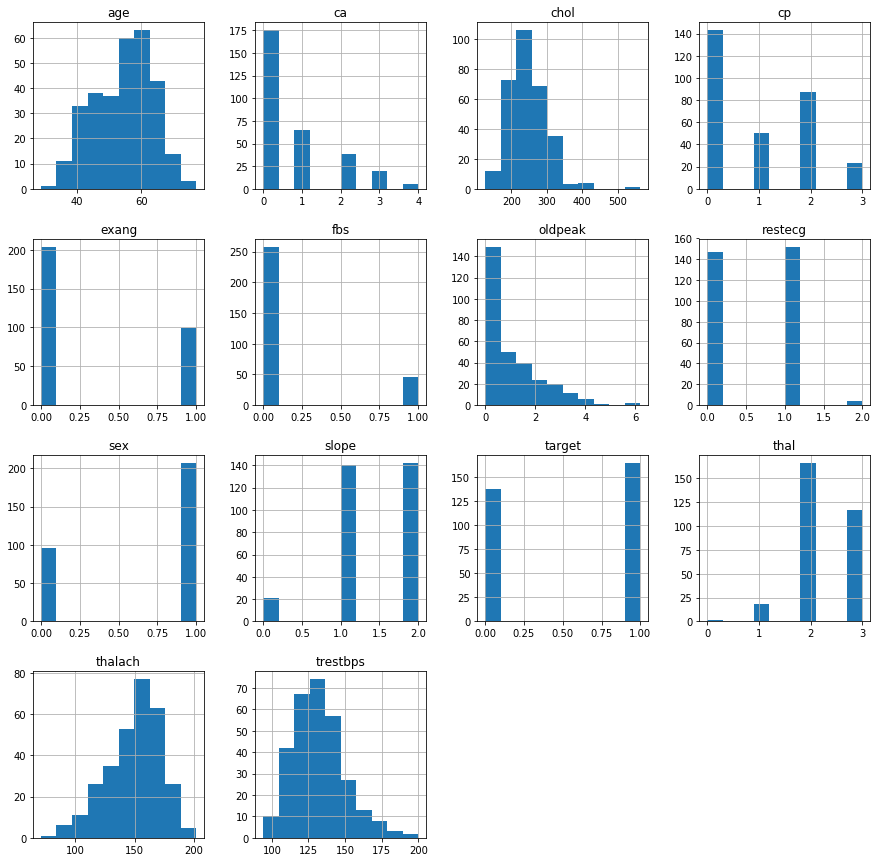

In [5]:
# Check the data distribution
df.hist(figsize=(15,15))

In [6]:
# Scaling (except categorical data)
scaler = MinMaxScaler()

# Category data found through the above distribution (to except)
columns_to_scale = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [7]:
# one hot encoding 
columns_to_dummies = ['cp','ca', 'thal','slope', 'restecg']
df[columns_to_dummies] = df[columns_to_dummies].astype('object')
one_hot_columns = pd.get_dummies(df[columns_to_dummies])
df = df.drop(columns_to_dummies,axis = 1)
df = df.join(one_hot_columns)

In [8]:
print(df.shape)
df.head()

(303, 28)


,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,target,cp_0,...,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2,restecg_0,restecg_1,restecg_2
0,0.708333,1,0.481132,0.244292,1,0.603053,0,0.370968,1,0,...,0,1,0,0,1,0,0,1,0,0
1,0.166667,1,0.339623,0.283105,0,0.885496,0,0.564516,1,0,...,0,0,1,0,1,0,0,0,1,0
2,0.250000,0,0.339623,0.178082,0,0.770992,0,0.225806,1,0,...,0,0,1,0,0,0,1,1,0,0
3,0.562500,1,0.245283,0.251142,0,0.816794,0,0.129032,1,0,...,0,0,1,0,0,0,1,0,1,0
4,0.583333,0,0.245283,0.520548,0,0.702290,1,0.096774,1,1,...,0,0,1,0,0,0,1,0,1,0


In [9]:
##############################################################

In [10]:
# split the label
y = df[['target']]
X = df.drop(['target'],axis =1)

In [11]:
# function to draw confusion matrix
# parameters: y_Acture, y_Predicted

def draw_confusion_matrix(y_test,y_pred):
    result= pd.DataFrame()

    result['y_test']= y_test['target']
    result['y_pred']= y_pred

    confusion_matrix = pd.crosstab(result['y_test'], result['y_pred'], margins=True)
    sns.heatmap(confusion_matrix, annot=True)
    
    return

In [12]:
# k fold cross validation and get average score
# parameters: X, y, model to run, confusion (True: draw confusion, False: skip drawing)
# return: 10-fold average score
def kfold_score (X,y,model, confusion = False):
    
    scores =[]
    kfold = KFold(n_splits=10, shuffle=True, random_state=42) 
    max_score = 0
    
    # do k-fold
    for train, test in kfold.split(X,y):       
        # training the model
        model.fit(X.iloc[train,:], y.iloc[train,:])       
        # get accuracy
        score = model.score(X.iloc[test,:], y.iloc[test,:]) 
        scores.append(score)
        
        # Store the best score of the 10 folds
        if confusion ==True:
            # save max score
            if max_score < score:
                max_score = score
                max_model = model
                max_X_test = X.iloc[test,:]
                max_y_test = y.iloc[test,:]
        
    
    # draw the confusion matrix and return average score
    if confusion == True:
        max_y_pred = max_model.predict(max_X_test)
        draw_confusion_matrix (max_y_test,max_y_pred)
        print('When score:', max_score)
        print('Average score(10-fold):', np.mean(scores))
        return np.mean(scores)
        
    # print the average score
    print('Average score(10-fold):', np.mean(scores))

    return

In [13]:
# make classifier and get 10-fold average score

In [14]:
# Model 1: Logistic Regression
logistic = LogisticRegression()
kfold_score(X,y,logistic)

Average score(10-fold): 0.8484946236559139


In [15]:
# Model 2:Decision Tree
dtree = DecisionTreeClassifier()
kfold_score(X,y,dtree)

Average score(10-fold): 0.7294623655913978


In [16]:
# Model 3: SVM
svm = SVC()
kfold_score(X,y,svm)

Average score(10-fold): 0.8613978494623655


In [17]:
##################################### Try various parameters
bestScores = {'model': ['logistic',' decisionTree','svm'], 'acc': []}
bestParmas = {'logistic':[], 'decisionTree':[], 'svm':[]}

In [18]:
#################### Model 1: Logistic Regression ######################

In [19]:
# First, Tune the solver
param_logistic = LogisticRegression (solver ='liblinear')
kfold_score(X,y,param_logistic)

Average score(10-fold): 0.8484946236559139


In [20]:
param_logistic = LogisticRegression (solver ='lbfgs')
kfold_score(X,y,param_logistic)

Average score(10-fold): 0.8418279569892473


In [21]:
param_logistic = LogisticRegression (solver ='sag')
kfold_score(X,y,param_logistic)

Average score(10-fold): 0.8418279569892473


In [22]:
# Set Solver = liblinear
# Second, Tune the max_iter

In [23]:
param_logistic = LogisticRegression (solver ='liblinear', max_iter =50)
kfold_score(X,y,param_logistic)

Average score(10-fold): 0.8484946236559139


In [24]:
param_logistic = LogisticRegression (solver ='liblinear', max_iter = 100)
kfold_score(X,y,param_logistic)

Average score(10-fold): 0.8484946236559139


In [25]:
param_logistic = LogisticRegression (solver ='liblinear', max_iter = 200)
kfold_score(X,y,param_logistic)

Average score(10-fold): 0.8484946236559139


When score: 0.967741935483871
Average score(10-fold): 0.8484946236559139


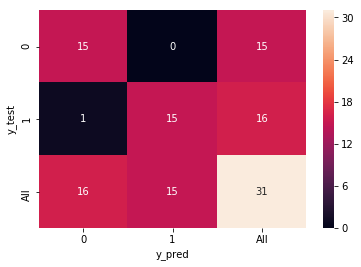

In [26]:
# Set solver = liblinear, max_iter = 50
# get maximum score and draw confusion matrix
param_logistic = LogisticRegression (solver ='liblinear', max_iter = 50)
acc = kfold_score(X,y,param_logistic, True)

# save model's score
bestScores['acc'].append(acc)

In [27]:
#################### Model 2: Decision Tree ######################

In [28]:
# Tune the criterion
param_dtree = DecisionTreeClassifier (criterion ='gini')
kfold_score(X,y,param_dtree)

Average score(10-fold): 0.7293548387096773


In [29]:
param_dtree = DecisionTreeClassifier (criterion ='entropy')
kfold_score(X,y,param_dtree)

Average score(10-fold): 0.7126881720430107


When score: 0.8064516129032258
Average score(10-fold): 0.7226881720430107


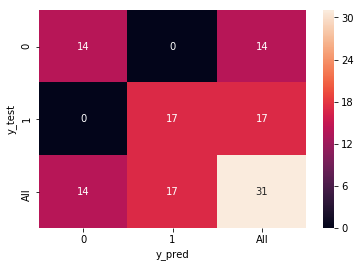

In [30]:
# Set criterion = gini
# get maximum score and draw confusion matrix
param_dtree = DecisionTreeClassifier (criterion ='gini')
acc = kfold_score(X,y,param_dtree, True)

# save model score
bestScores['acc'].append(acc)

In [31]:
#################### Model 3: svm ######################

In [32]:
# First, Tune the C
param_svm = SVC (C = 0.1)
kfold_score(X,y,param_svm)

Average score(10-fold): 0.8547311827956989


In [33]:
param_svm = SVC (C = 1.0)
kfold_score(X,y,param_svm)

Average score(10-fold): 0.8613978494623655


In [34]:
param_svm = SVC (C = 10.0)
kfold_score(X,y,param_svm)

Average score(10-fold): 0.828494623655914


In [35]:
# Set the C = 1.0
# Second, tune the kernel

In [36]:
param_svm = SVC (C = 1.0, kernel = 'linear')
kfold_score(X,y,param_svm)

Average score(10-fold): 0.8449462365591399


In [37]:
param_svm = SVC (C = 1.0, kernel = 'poly')
kfold_score(X,y,param_svm)

Average score(10-fold): 0.5741935483870966


In [38]:
param_svm = SVC (C = 1.0, kernel = 'rbf')
kfold_score(X,y,param_svm)

Average score(10-fold): 0.8613978494623655


In [39]:
param_svm = SVC (C = 1.0, kernel = 'sigmoid')
kfold_score(X,y,param_svm)

Average score(10-fold): 0.8482795698924731


In [40]:
# Set the C = 1.0, kernel ='rbf'
# Third, tune the kernel

In [41]:
param_svm = SVC (C = 1.0, kernel = 'rbf', gamma = 10)
kfold_score(X,y,param_svm)

Average score(10-fold): 0.6732258064516129


In [42]:
param_svm = SVC (C = 1.0, kernel = 'rbf', gamma = 100)
kfold_score(X,y,param_svm)

Average score(10-fold): 0.5444086021505375


When score: 0.967741935483871
Average score(10-fold): 0.8613978494623655


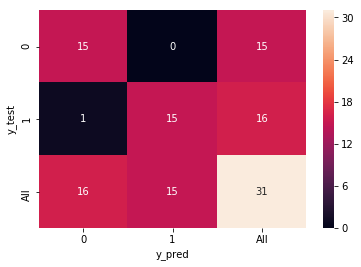

In [43]:
# Set the C = 1.0, kernel ='rbf'
# get maximum score and draw confusion matrix
param_svm = SVC (C = 1.0, kernel = 'rbf')
acc = kfold_score(X,y,param_svm, True)

# save model score
bestScores['acc'].append(acc)

In [44]:
bestScores

{'model': ['logistic', ' decisionTree', 'svm'],
 'acc': [0.8484946236559139, 0.7226881720430107, 0.8613978494623655]}

In [45]:
############################## draw bar chart

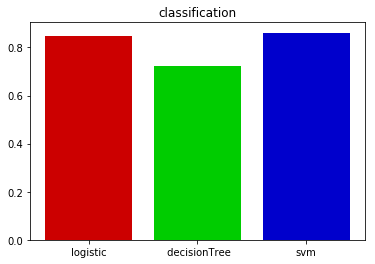

In [46]:
plt.title ('classification')
plt.bar(bestScores['model'], bestScores['acc'], color = [(0.8,0,0), (0,0.8,0), (0,0,0.8)])
plt.show()